# 라이브러리 불러오기

In [1]:
#필요한 library 들을 load 합니다.
import os 
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from torchvision import datasets, transforms
from PIL import Image

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, RandomSampler, SequentialSampler, ConcatDataset
from torchvision import models

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Augmenting library 
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# from glob import glob
# import shutil 


# classes = os.listdir('./data/train/')

# for cls in classes:
#     # 폴더 안에 얼마나 들어갔나
#     n_imgs = len(os.listdir('./data/train/'+ str(cls)))
#     np.sample()
#     print(n_imgs)
#     break

In [3]:
# cifar10_train = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
# cifar10_test = datasets.CIFAR10(root='./data', train=True, transform=None, download=True)

# 데이터 load

이후 추가할 데이터 정규화를 위해, Train 데이터를 모두 훑어주면서 평균과 분산을 찾아줍니다.

In [4]:
temp_transform = T.Compose([
    T.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    # T.Resize([224, 224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #픽셀 단위 데이터를 정규화 시켜줍니다.
])

In [5]:
train_data = datasets.ImageFolder(root='./data/train/',transform=temp_transform)
print(len(train_data))

50000


임시 dataloader로 데이터를 로드해 줍니다. 

전체 데이터를 훑을 것이기 때문에, 이때 batch_size는 데이터 전체의 길이로 해줍니다.

보통은 하드웨어 성능에 맞춰주며, 최적의 batch_size는 여러분이 정해야 할 하이퍼파라미터입니다.

In [6]:
temp_loader = DataLoader(train_data, batch_size=len(train_data), num_workers=1)
data = next(iter(temp_loader))

데이터 차원 : 갯수 x RGB채널 (C) x 높이(H) x 너비(W)

In [7]:
data[0].shape

torch.Size([50000, 3, 32, 32])

RGB 채널별로 평균과 표준편차를 구해줍니다.

데이터 정규화를 시켜주는 이유는 간단히 다음과 같습니다.

1. 평균을 0, 분산을 1로 만들어줌으로써 학습 속도를 증가

2. Train/Val 과 Test 데이터의 분포가 다름(Dataset Shift Problem)으로써 나오는 악영향을 줄임

등등, https://hyen4110.tistory.com/20

In [8]:
R_mean = data[0][:, 0].mean().numpy()
G_mean = data[0][:, 1].mean().numpy()
B_mean = data[0][:, 2].mean().numpy()

R_std = data[0][:, 0].std().numpy()
G_std = data[0][:, 1].std().numpy()
B_std = data[0][:, 2].std().numpy()

print(R_mean, G_mean, B_mean, R_std, G_std, B_std)

0.49125063 0.48208764 0.44651157 0.24574625 0.24295063 0.26109803


Pytorch는 String 형태의 레이블을 입력받지 못하므로, 숫자형태로 매핑해줍니다.

In [9]:
submission = pd.read_csv('./data/sample_submission.csv')
train_imgs = glob('./data/train/*/*')
train_labels = [path.split('\\')[1] for path in train_imgs]
test_imgs = glob('./data/test/*')

# Pytorch는 String 형태의 label을 입력받지 못합니다.
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

# Dataset 정의

In [10]:
class train_dataset(Dataset):
    def __init__(self, imgs, labels, transform = None):
        super(train_dataset, self).__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        assert len(self.imgs) == len(self.labels)
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        y = label_map[self.labels[idx]]
        
        if self.transform:
            img = self.transform(image = X)['image']
        else:
            img = X
    
        y = torch.tensor(y, dtype = torch.long)
        return {
            'img' : img,
            'label' : y
        }
    
class test_dataset(Dataset):
    def __init__(self, imgs, transform = None):
        super(test_dataset, self).__init__()
        self.imgs = imgs
        self.transform = transform
        # self.n_tta = n_tta
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        if self.transform:
            img = self.transform(image = X)['image']
            return img
        else:
            return X

# Config

하이퍼파라미터들을 설정해 줍니다.

batch_size 란 하드웨어에 한번에 load 할 데이터의 크기입니다. 

num_workers 란 데이터 로드 멀티 프로세싱을 위한 파라미터입니다. Windows에서는 따로 설정하면 에러납니다.

Train 데이터 batch_size는 적당한 값, val/test 데이터는 하드웨어가 감당하는 최대한 큰 값으로 하면 좋습니다.

In [11]:
re_size = 128

train_batch_size = 64
valid_batch_size = 128
test_batch_size = 127

epochs = 100
learning_rate = train_batch_size * 1e-5

save_name = f'js_effb4_r{re_size}_b{train_batch_size}_lr{learning_rate}_e{epochs}'
save_path = f'models/{save_name}.pt'

# 데이터 증강 (Augmentation)

데이터 형태마다 고유의 증강 기법이 존재합니다. 

증강을 통해 Train 데이터에 변형을 주어 다양성(Variability)를 높이고, Bias를 낮춰 앞서 말한 Dataset shift 문제에 대처할 수 있습니다.

즉, 과적합(Overfitting)에 조금 더 강건한 모델을 만들 수 있습니다.

이미지에는 다음과 같은 증강 기법들이 존재합니다. 컴퓨터 비전 관련한 수업을 들으신 분들은 익숙하실 것입니다.
1. 픽셀 단위 증강 : 가우시안 블러링, 가우시안 노이즈 추가, 픽셀 정규화, Grayscaling 등
2. 공간 수준 증강(Spatial-level Augmentation): Resize, Crop, Rotate, Flip, Shift 등 

- 이외에도 Cutout, Mixup, CutMix, Augmix 등 다양한 증강 기법들이 개발되고 있습니다.

**Validation 및 Test 데이터에는 Augmentation을 적용하면 안 됩니다. (정규화 제외)**
- Test-time Augmentation(TTA)라는 기법이 있긴 하지만, 여기서는 적용하지 않겠습니다.

In [12]:
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose([
    A.Resize(re_size, re_size, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.GaussNoise(p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit = 3, p = 1.0),
        A.MedianBlur(blur_limit = 3, p = 1.0),
        A.Blur(blur_limit = 3, p = 1.0),
        ], p = 0.3),
    A.ShiftScaleRotate(rotate_limit = 30),
    A.OneOf([
        A.OpticalDistortion(p = 1.0),
        A.GridDistortion(p = 1.0),
        ], p = 0.3),
    A.OneOf([
        A.CLAHE(clip_limit = 2),
        A.RandomBrightnessContrast(),
        ], p = 0.3),
    A.HueSaturationValue(p = 0.3),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

else_transform = A.Compose([
    A.Resize(re_size, re_size, interpolation=cv2.INTER_AREA),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

Train/Val split

In [13]:
train_data = datasets.ImageFolder(root='./data/train/',transform=temp_transform)
train_imgs = glob('./data/train/*/*')
train_labels = [path.split('\\')[1] for path in train_imgs]
test_imgs = glob('./data/test/*')

# Pytorch는 String 형태의 label을 입력받지 못합니다.
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size = 0.2,
                                                                  stratify = train_labels, random_state = 42)
len(train_imgs), len(val_imgs), len(train_labels), len(val_labels)

(40000, 10000, 40000, 10000)

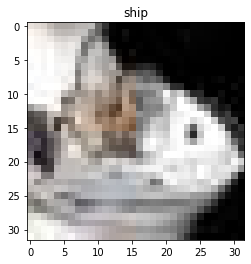

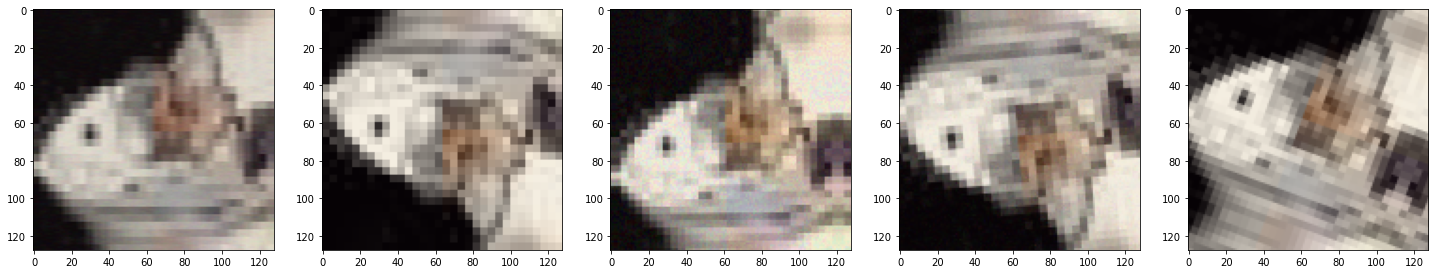

In [14]:
def display_aug(imgs, transform, labels = None, n_aug = 5, cols = 5):
    idx = random.randint(0, len(imgs) - 1)
    
    plt.imshow(np.array(Image.open(imgs[idx])))
    
    if labels:
        label = labels[idx]
        plt.title(label)
    plt.show()
    
    rows = int(np.ceil(n_aug / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 5, rows * 5))

    for i in range(n_aug):
        img = np.array(Image.open(imgs[idx]))
        img = transform(image = img)['image']
        img = np.clip(img.numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        axes.flat[i].imshow(img)
    plt.show()

display_aug(train_imgs, train_transform, labels = train_labels)

data loader 를 생성해줍니다. 

data loader 란 데이터 셋을 순회하며 모델에 데이터를 넣어주는 객체입니다. 

In [15]:
train_loader = DataLoader(train_dataset(train_imgs, train_labels, transform = train_transform),
                          shuffle = True, batch_size = train_batch_size)
val_loader = DataLoader(train_dataset(val_imgs, val_labels, transform = else_transform),
                        shuffle = False, batch_size = valid_batch_size)

In [16]:
next(iter(train_loader))['img'].shape, next(iter(train_loader))['label']

# (B, C, H, W), (B, num_classes)

(torch.Size([64, 3, 128, 128]),
 tensor([5, 8, 6, 4, 4, 7, 7, 6, 0, 0, 4, 9, 8, 5, 5, 5, 9, 3, 3, 5, 8, 4, 5, 3,
         7, 6, 3, 6, 3, 0, 7, 5, 4, 4, 3, 7, 7, 3, 7, 0, 8, 6, 4, 0, 0, 3, 3, 0,
         1, 7, 2, 5, 9, 0, 6, 2, 0, 8, 5, 0, 1, 4, 1, 1]))

# Device 설정

device 를 설정해줍니다.

이번 베이스라인에서는 gpu 가 있다고 가정하겠습니다. 

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

# Model

전이학습을 위한 모델을 load 해줍니다. 

PYTORCH 의 models 메소드를 사용하면 손쉽게 외부의 모델을 불러올 수 있습니다.

이번 베이스라인에서는 efficientnet_b3 모델을 사용해 볼 것입니다. 

사전 학습 모델을 사용하는 것은 부정행위에 해당하니, pretrained 파라미터를 False 로 설정해야 합니다!

pretrained 파라미터를 True 로 설정한다면, ImageNet 이라는 데이터셋을 대상으로 학습된 모델이 load 됩니다.

반면, pretrained 파라미터를 False 로 설정한다면, 모델의 구조만 load 되고 모델의 가중치 들은 load 되지 않습니다. 

In [18]:
model = models.efficientnet_b4(pretrained=False)

In [19]:
model.classifier

Sequential(
  (0): Dropout(p=0.4, inplace=True)
  (1): Linear(in_features=1792, out_features=1000, bias=True)
)

모델에 데이터를 학습하기 위해서는 모델의 마지막 layer 의 output size 와 분류할 라벨의 수를 입력해주어야 합니다.

즉, 끝단만 바꿔줍니다.

In [20]:
model.classifier[1] = nn.Linear(1792, 10)

In [21]:
sample_img = next(iter(train_loader))['img']
sample_lab = next(iter(train_loader))['label']
model(sample_img)[0], sample_lab[0]

(tensor([-0.0344,  0.0107, -0.0552,  0.0004,  0.0234,  0.0213,  0.0086, -0.0364,
         -0.0219, -0.0884], grad_fn=<SelectBackward0>),
 tensor(2))

In [22]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)

# 학습 

train/validate 함수를 따로 정의해주었습니다.

In [23]:
from sklearn.metrics import f1_score 
import gc

def train(model, loader, epoch, nb_epochs):
    print(f'Epoch {epoch+1}/{nb_epochs}')
    running_loss = 0.0
    # running_f1 = 0.0
    running_corrects = 0
    model.train()
    # scaler = torch.cuda.amp.GradScaler()
    # y_true = []
    # y_pred = []

    for idx, batch in enumerate(tqdm(loader)):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # with torch.cuda.amp.autocast():
        #     output = model(img, csv_feature)
        #     loss = criterion(output, label)

        # scaler.scale(loss).backward() # ADDED - mixed precision + gradient clipping
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        # scaler.step(optimizer)
        # scaler.update()
        
        # forward + backward + optimize
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects+=correct

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    # epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    # epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    # writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    # writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)

    # print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f},\
    # lr: {optimizer.param_groups[0]["lr"]:.6f}')
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')    
    # scheduler.step()
    
def validate(model, loader, epoch, nb_epochs):
    running_loss = 0.0
    # running_f1 = 0.0
    running_corrects = 0
    model.eval()
    # y_true = []
    # y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects+=correct


        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = running_corrects / len(loader.dataset)
        # epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        # epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        # writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        # writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'{running_corrects}/{len(loader.dataset)} correct' )
        # print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}')
        
        val_acc_list.append(epoch_acc.cpu().numpy())
        # val_f1_macro_list.append(epoch_f1_macro)
        # val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_acc_list) == val_acc_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            print(f'Saving, ACC: {val_acc_list[-1]:.6f}')
            torch.save(model.state_dict(), save_path)
            

gc.collect()

18105

In [24]:
print(save_name)
print(save_path)

js_effb4_r128_b64_lr0.00064_e100
models/js_effb4_r128_b64_lr0.00064_e100.pt


In [25]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)
val_acc_list = []
model.to(device)

for epoch in range(epochs):
    train(model, train_loader, epoch, epochs)
    validate(model, val_loader, epoch, epochs)

Epoch 1/100


100%|██████████| 625/625 [02:37<00:00,  3.96it/s]


Train loss: 1.972856, Train ACC: 0.242200, lr: 0.000640
3151/10000 correct
Valid loss: 1.738428, Valid ACC: 0.315100
Saving, ACC: 0.315100
Epoch 2/100


100%|██████████| 625/625 [02:34<00:00,  4.03it/s]


Train loss: 1.670916, Train ACC: 0.369300, lr: 0.000640
4986/10000 correct
Valid loss: 1.379506, Valid ACC: 0.498600
Saving, ACC: 0.498600
Epoch 3/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 1.482289, Train ACC: 0.456050, lr: 0.000640
5648/10000 correct
Valid loss: 1.239212, Valid ACC: 0.564800
Saving, ACC: 0.564800
Epoch 4/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 1.416325, Train ACC: 0.485425, lr: 0.000640
4746/10000 correct
Valid loss: 1.444179, Valid ACC: 0.474600
Epoch 5/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 1.326483, Train ACC: 0.525275, lr: 0.000640
6492/10000 correct
Valid loss: 1.015235, Valid ACC: 0.649200
Saving, ACC: 0.649200
Epoch 6/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 1.218202, Train ACC: 0.566950, lr: 0.000640
6547/10000 correct
Valid loss: 0.975023, Valid ACC: 0.654700
Saving, ACC: 0.654700
Epoch 7/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 1.138581, Train ACC: 0.594550, lr: 0.000640
6939/10000 correct
Valid loss: 0.878162, Valid ACC: 0.693900
Saving, ACC: 0.693900
Epoch 8/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 1.078156, Train ACC: 0.617625, lr: 0.000640
7141/10000 correct
Valid loss: 0.832262, Valid ACC: 0.714100
Saving, ACC: 0.714100
Epoch 9/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.997018, Train ACC: 0.649850, lr: 0.000640
7348/10000 correct
Valid loss: 0.759962, Valid ACC: 0.734800
Saving, ACC: 0.734800
Epoch 10/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.911084, Train ACC: 0.680175, lr: 0.000640
7595/10000 correct
Valid loss: 0.715392, Valid ACC: 0.759500
Saving, ACC: 0.759500
Epoch 11/100


100%|██████████| 625/625 [02:36<00:00,  4.00it/s]


Train loss: 0.894189, Train ACC: 0.684300, lr: 0.000640
7575/10000 correct
Valid loss: 0.720356, Valid ACC: 0.757500
Epoch 12/100


100%|██████████| 625/625 [02:36<00:00,  4.00it/s]


Train loss: 0.852790, Train ACC: 0.698875, lr: 0.000640
7852/10000 correct
Valid loss: 0.635324, Valid ACC: 0.785200
Saving, ACC: 0.785200
Epoch 13/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.877102, Train ACC: 0.693900, lr: 0.000640
7611/10000 correct
Valid loss: 0.688597, Valid ACC: 0.761100
Epoch 14/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.831591, Train ACC: 0.709550, lr: 0.000640
7979/10000 correct
Valid loss: 0.597134, Valid ACC: 0.797900
Saving, ACC: 0.797900
Epoch 15/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.759748, Train ACC: 0.736925, lr: 0.000640
6791/10000 correct
Valid loss: 0.946266, Valid ACC: 0.679100
Epoch 16/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.790672, Train ACC: 0.721875, lr: 0.000640
7946/10000 correct
Valid loss: 0.596813, Valid ACC: 0.794600
Epoch 17/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.722672, Train ACC: 0.748575, lr: 0.000640
7982/10000 correct
Valid loss: 0.595481, Valid ACC: 0.798200
Saving, ACC: 0.798200
Epoch 18/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.743288, Train ACC: 0.740825, lr: 0.000640
8091/10000 correct
Valid loss: 0.549570, Valid ACC: 0.809100
Saving, ACC: 0.809100
Epoch 19/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.699687, Train ACC: 0.756825, lr: 0.000640
8199/10000 correct
Valid loss: 0.528181, Valid ACC: 0.819900
Saving, ACC: 0.819900
Epoch 20/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.688272, Train ACC: 0.761400, lr: 0.000640
8180/10000 correct
Valid loss: 0.538015, Valid ACC: 0.818000
Epoch 21/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.651856, Train ACC: 0.773475, lr: 0.000640
8038/10000 correct
Valid loss: 0.588929, Valid ACC: 0.803800
Epoch 22/100


100%|██████████| 625/625 [02:34<00:00,  4.05it/s]


Train loss: 0.636660, Train ACC: 0.776150, lr: 0.000640
8312/10000 correct
Valid loss: 0.486832, Valid ACC: 0.831200
Saving, ACC: 0.831200
Epoch 23/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.602477, Train ACC: 0.788800, lr: 0.000640
8327/10000 correct
Valid loss: 0.484372, Valid ACC: 0.832700
Saving, ACC: 0.832700
Epoch 24/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.584196, Train ACC: 0.796800, lr: 0.000640
8365/10000 correct
Valid loss: 0.467334, Valid ACC: 0.836500
Saving, ACC: 0.836500
Epoch 25/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.608562, Train ACC: 0.789775, lr: 0.000640
8316/10000 correct
Valid loss: 0.483268, Valid ACC: 0.831600
Epoch 26/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.579148, Train ACC: 0.797675, lr: 0.000640
8388/10000 correct
Valid loss: 0.464564, Valid ACC: 0.838800
Saving, ACC: 0.838800
Epoch 27/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.564035, Train ACC: 0.803600, lr: 0.000640
8381/10000 correct
Valid loss: 0.461835, Valid ACC: 0.838100
Epoch 28/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.544651, Train ACC: 0.810725, lr: 0.000640
8464/10000 correct
Valid loss: 0.450797, Valid ACC: 0.846400
Saving, ACC: 0.846400
Epoch 29/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.524055, Train ACC: 0.816375, lr: 0.000640
8424/10000 correct
Valid loss: 0.459505, Valid ACC: 0.842400
Epoch 30/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.509748, Train ACC: 0.822600, lr: 0.000640
8466/10000 correct
Valid loss: 0.442475, Valid ACC: 0.846600
Saving, ACC: 0.846600
Epoch 31/100


100%|██████████| 625/625 [02:36<00:00,  4.00it/s]


Train loss: 0.503274, Train ACC: 0.822700, lr: 0.000640
8442/10000 correct
Valid loss: 0.447905, Valid ACC: 0.844200
Epoch 32/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.491993, Train ACC: 0.829350, lr: 0.000640
8481/10000 correct
Valid loss: 0.446411, Valid ACC: 0.848100
Saving, ACC: 0.848100
Epoch 33/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.500626, Train ACC: 0.824950, lr: 0.000640
8550/10000 correct
Valid loss: 0.431038, Valid ACC: 0.855000
Saving, ACC: 0.855000
Epoch 34/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.471922, Train ACC: 0.835175, lr: 0.000640
8615/10000 correct
Valid loss: 0.405316, Valid ACC: 0.861500
Saving, ACC: 0.861500
Epoch 35/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.448756, Train ACC: 0.845100, lr: 0.000640
8405/10000 correct
Valid loss: 0.453647, Valid ACC: 0.840500
Epoch 36/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.504159, Train ACC: 0.824350, lr: 0.000640
8514/10000 correct
Valid loss: 0.422297, Valid ACC: 0.851400
Epoch 37/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.449805, Train ACC: 0.845100, lr: 0.000640
8536/10000 correct
Valid loss: 0.420174, Valid ACC: 0.853600
Epoch 38/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.426508, Train ACC: 0.851600, lr: 0.000640
8674/10000 correct
Valid loss: 0.386048, Valid ACC: 0.867400
Saving, ACC: 0.867400
Epoch 39/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.412983, Train ACC: 0.856300, lr: 0.000640
8642/10000 correct
Valid loss: 0.403223, Valid ACC: 0.864200
Epoch 40/100


100%|██████████| 625/625 [02:34<00:00,  4.03it/s]


Train loss: 0.414482, Train ACC: 0.855800, lr: 0.000640
8636/10000 correct
Valid loss: 0.398634, Valid ACC: 0.863600
Epoch 41/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.413557, Train ACC: 0.855425, lr: 0.000640
8644/10000 correct
Valid loss: 0.400692, Valid ACC: 0.864400
Epoch 42/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.435569, Train ACC: 0.849650, lr: 0.000640
8527/10000 correct
Valid loss: 0.435577, Valid ACC: 0.852700
Epoch 43/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.442282, Train ACC: 0.846400, lr: 0.000640
8510/10000 correct
Valid loss: 0.424707, Valid ACC: 0.851000
Epoch 44/100


100%|██████████| 625/625 [02:34<00:00,  4.03it/s]


Train loss: 0.425869, Train ACC: 0.852500, lr: 0.000640
8677/10000 correct
Valid loss: 0.387614, Valid ACC: 0.867700
Saving, ACC: 0.867700
Epoch 45/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.380901, Train ACC: 0.866875, lr: 0.000640
8702/10000 correct
Valid loss: 0.379769, Valid ACC: 0.870200
Saving, ACC: 0.870200
Epoch 46/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.377499, Train ACC: 0.867875, lr: 0.000640
8712/10000 correct
Valid loss: 0.373435, Valid ACC: 0.871200
Saving, ACC: 0.871200
Epoch 47/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.376331, Train ACC: 0.867100, lr: 0.000640
8754/10000 correct
Valid loss: 0.380166, Valid ACC: 0.875400
Saving, ACC: 0.875400
Epoch 48/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.370288, Train ACC: 0.869800, lr: 0.000640
8665/10000 correct
Valid loss: 0.394555, Valid ACC: 0.866500
Epoch 49/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.356854, Train ACC: 0.874225, lr: 0.000640
8727/10000 correct
Valid loss: 0.381962, Valid ACC: 0.872700
Epoch 50/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.349899, Train ACC: 0.879275, lr: 0.000640
8726/10000 correct
Valid loss: 0.380807, Valid ACC: 0.872600
Epoch 51/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.341255, Train ACC: 0.881275, lr: 0.000640
8647/10000 correct
Valid loss: 0.397047, Valid ACC: 0.864700
Epoch 52/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.336516, Train ACC: 0.884475, lr: 0.000640
8764/10000 correct
Valid loss: 0.365483, Valid ACC: 0.876400
Saving, ACC: 0.876400
Epoch 53/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.320039, Train ACC: 0.888775, lr: 0.000640
8766/10000 correct
Valid loss: 0.368641, Valid ACC: 0.876600
Saving, ACC: 0.876600
Epoch 54/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.312632, Train ACC: 0.889325, lr: 0.000640
8716/10000 correct
Valid loss: 0.389818, Valid ACC: 0.871600
Epoch 55/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.312253, Train ACC: 0.891425, lr: 0.000640
8764/10000 correct
Valid loss: 0.371991, Valid ACC: 0.876400
Epoch 56/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.321575, Train ACC: 0.888050, lr: 0.000640
8753/10000 correct
Valid loss: 0.381091, Valid ACC: 0.875300
Epoch 57/100


100%|██████████| 625/625 [02:36<00:00,  3.98it/s]


Train loss: 0.315835, Train ACC: 0.890200, lr: 0.000640
8748/10000 correct
Valid loss: 0.376293, Valid ACC: 0.874800
Epoch 58/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.295688, Train ACC: 0.896575, lr: 0.000640
8779/10000 correct
Valid loss: 0.370510, Valid ACC: 0.877900
Saving, ACC: 0.877900
Epoch 59/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.297760, Train ACC: 0.897075, lr: 0.000640
8784/10000 correct
Valid loss: 0.367700, Valid ACC: 0.878400
Saving, ACC: 0.878400
Epoch 60/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.284951, Train ACC: 0.901100, lr: 0.000640
8777/10000 correct
Valid loss: 0.369703, Valid ACC: 0.877700
Epoch 61/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.276458, Train ACC: 0.900800, lr: 0.000640
8740/10000 correct
Valid loss: 0.382577, Valid ACC: 0.874000
Epoch 62/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.279028, Train ACC: 0.901650, lr: 0.000640
8804/10000 correct
Valid loss: 0.376444, Valid ACC: 0.880400
Saving, ACC: 0.880400
Epoch 63/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.291143, Train ACC: 0.900375, lr: 0.000640
8763/10000 correct
Valid loss: 0.374316, Valid ACC: 0.876300
Epoch 64/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.269483, Train ACC: 0.905525, lr: 0.000640
8742/10000 correct
Valid loss: 0.380747, Valid ACC: 0.874200
Epoch 65/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.256792, Train ACC: 0.910325, lr: 0.000640
8807/10000 correct
Valid loss: 0.373878, Valid ACC: 0.880700
Saving, ACC: 0.880700
Epoch 66/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.276759, Train ACC: 0.904300, lr: 0.000640
8752/10000 correct
Valid loss: 0.394017, Valid ACC: 0.875200
Epoch 67/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.270601, Train ACC: 0.908850, lr: 0.000640
8815/10000 correct
Valid loss: 0.363869, Valid ACC: 0.881500
Saving, ACC: 0.881500
Epoch 68/100


100%|██████████| 625/625 [02:34<00:00,  4.03it/s]


Train loss: 0.246140, Train ACC: 0.916175, lr: 0.000640
8861/10000 correct
Valid loss: 0.362904, Valid ACC: 0.886100
Saving, ACC: 0.886100
Epoch 69/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.243948, Train ACC: 0.915850, lr: 0.000640
8857/10000 correct
Valid loss: 0.364616, Valid ACC: 0.885700
Epoch 70/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.264436, Train ACC: 0.909150, lr: 0.000640
8836/10000 correct
Valid loss: 0.358729, Valid ACC: 0.883600
Epoch 71/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.235175, Train ACC: 0.918625, lr: 0.000640
8840/10000 correct
Valid loss: 0.365609, Valid ACC: 0.884000
Epoch 72/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.243842, Train ACC: 0.916175, lr: 0.000640
8844/10000 correct
Valid loss: 0.355664, Valid ACC: 0.884400
Epoch 73/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.233185, Train ACC: 0.919625, lr: 0.000640
8731/10000 correct
Valid loss: 0.411151, Valid ACC: 0.873100
Epoch 74/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.226754, Train ACC: 0.922700, lr: 0.000640
8849/10000 correct
Valid loss: 0.373405, Valid ACC: 0.884900
Epoch 75/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.227569, Train ACC: 0.921750, lr: 0.000640
8843/10000 correct
Valid loss: 0.365251, Valid ACC: 0.884300
Epoch 76/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.218617, Train ACC: 0.925300, lr: 0.000640
8829/10000 correct
Valid loss: 0.368527, Valid ACC: 0.882900
Epoch 77/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.226446, Train ACC: 0.921725, lr: 0.000640
8836/10000 correct
Valid loss: 0.362116, Valid ACC: 0.883600
Epoch 78/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.218693, Train ACC: 0.924350, lr: 0.000640
8843/10000 correct
Valid loss: 0.368574, Valid ACC: 0.884300
Epoch 79/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.207702, Train ACC: 0.928150, lr: 0.000640
8827/10000 correct
Valid loss: 0.388533, Valid ACC: 0.882700
Epoch 80/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.207798, Train ACC: 0.927650, lr: 0.000640
8803/10000 correct
Valid loss: 0.382755, Valid ACC: 0.880300
Epoch 81/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.201731, Train ACC: 0.930925, lr: 0.000640
8865/10000 correct
Valid loss: 0.369514, Valid ACC: 0.886500
Saving, ACC: 0.886500
Epoch 82/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.204139, Train ACC: 0.929225, lr: 0.000640
8842/10000 correct
Valid loss: 0.371710, Valid ACC: 0.884200
Epoch 83/100


100%|██████████| 625/625 [02:34<00:00,  4.03it/s]


Train loss: 0.196825, Train ACC: 0.931825, lr: 0.000640
8834/10000 correct
Valid loss: 0.373297, Valid ACC: 0.883400
Epoch 84/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.210214, Train ACC: 0.926300, lr: 0.000640
8837/10000 correct
Valid loss: 0.373127, Valid ACC: 0.883700
Epoch 85/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.198203, Train ACC: 0.931900, lr: 0.000640
8866/10000 correct
Valid loss: 0.371687, Valid ACC: 0.886600
Saving, ACC: 0.886600
Epoch 86/100


100%|██████████| 625/625 [02:34<00:00,  4.03it/s]


Train loss: 0.188032, Train ACC: 0.936400, lr: 0.000640
8882/10000 correct
Valid loss: 0.364863, Valid ACC: 0.888200
Saving, ACC: 0.888200
Epoch 87/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.192274, Train ACC: 0.934000, lr: 0.000640
8785/10000 correct
Valid loss: 0.401691, Valid ACC: 0.878500
Epoch 88/100


100%|██████████| 625/625 [02:34<00:00,  4.04it/s]


Train loss: 0.212230, Train ACC: 0.927725, lr: 0.000640
8861/10000 correct
Valid loss: 0.369711, Valid ACC: 0.886100
Epoch 89/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.189973, Train ACC: 0.934500, lr: 0.000640
8829/10000 correct
Valid loss: 0.373356, Valid ACC: 0.882900
Epoch 90/100


100%|██████████| 625/625 [02:34<00:00,  4.03it/s]


Train loss: 0.181171, Train ACC: 0.938375, lr: 0.000640
8843/10000 correct
Valid loss: 0.386528, Valid ACC: 0.884300
Epoch 91/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.179291, Train ACC: 0.940025, lr: 0.000640
8878/10000 correct
Valid loss: 0.366111, Valid ACC: 0.887800
Epoch 92/100


100%|██████████| 625/625 [02:34<00:00,  4.05it/s]


Train loss: 0.177042, Train ACC: 0.938875, lr: 0.000640
8854/10000 correct
Valid loss: 0.390543, Valid ACC: 0.885400
Epoch 93/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.181430, Train ACC: 0.937650, lr: 0.000640
8823/10000 correct
Valid loss: 0.382178, Valid ACC: 0.882300
Epoch 94/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.180608, Train ACC: 0.938300, lr: 0.000640
8838/10000 correct
Valid loss: 0.378910, Valid ACC: 0.883800
Epoch 95/100


100%|██████████| 625/625 [02:35<00:00,  4.01it/s]


Train loss: 0.165680, Train ACC: 0.943125, lr: 0.000640
8880/10000 correct
Valid loss: 0.370709, Valid ACC: 0.888000
Epoch 96/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.172455, Train ACC: 0.942875, lr: 0.000640
8856/10000 correct
Valid loss: 0.376423, Valid ACC: 0.885600
Epoch 97/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.170082, Train ACC: 0.941725, lr: 0.000640
8806/10000 correct
Valid loss: 0.398787, Valid ACC: 0.880600
Epoch 98/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.164565, Train ACC: 0.943025, lr: 0.000640
8845/10000 correct
Valid loss: 0.397736, Valid ACC: 0.884500
Epoch 99/100


100%|██████████| 625/625 [02:35<00:00,  4.02it/s]


Train loss: 0.168689, Train ACC: 0.941050, lr: 0.000640
8837/10000 correct
Valid loss: 0.382592, Valid ACC: 0.883700
Epoch 100/100


100%|██████████| 625/625 [02:35<00:00,  4.03it/s]


Train loss: 0.172666, Train ACC: 0.942275, lr: 0.000640
8873/10000 correct
Valid loss: 0.375358, Valid ACC: 0.887300


저장된 Weight를 입혀주고, Valid set에 대한 Confusion Matrix를 그려봅니다.

In [26]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [27]:
train_y_true = []
train_y_pred = []
val_y_true = []
val_y_pred = []

with torch.no_grad():
    for idx, batch in enumerate(train_loader):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)

        for item in label.cpu().numpy():
            train_y_true.append(item)
        for item in preds.cpu().numpy():
            train_y_pred.append(item)

    for idx, batch in enumerate(val_loader):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)
        
        for item in label.cpu().numpy():
            val_y_true.append(item)
        for item in preds.cpu().numpy():
            val_y_pred.append(item)

In [28]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

train_y_true = pd.DataFrame(train_y_true).apply(lambda x : x.map(labels))
train_y_pred = pd.DataFrame(train_y_pred).apply(lambda x : x.map(labels))
val_y_true = pd.DataFrame(val_y_true).apply(lambda x : x.map(labels))
val_y_pred = pd.DataFrame(val_y_pred).apply(lambda x : x.map(labels))

In [29]:
np.max(val_acc_list)

0.8882

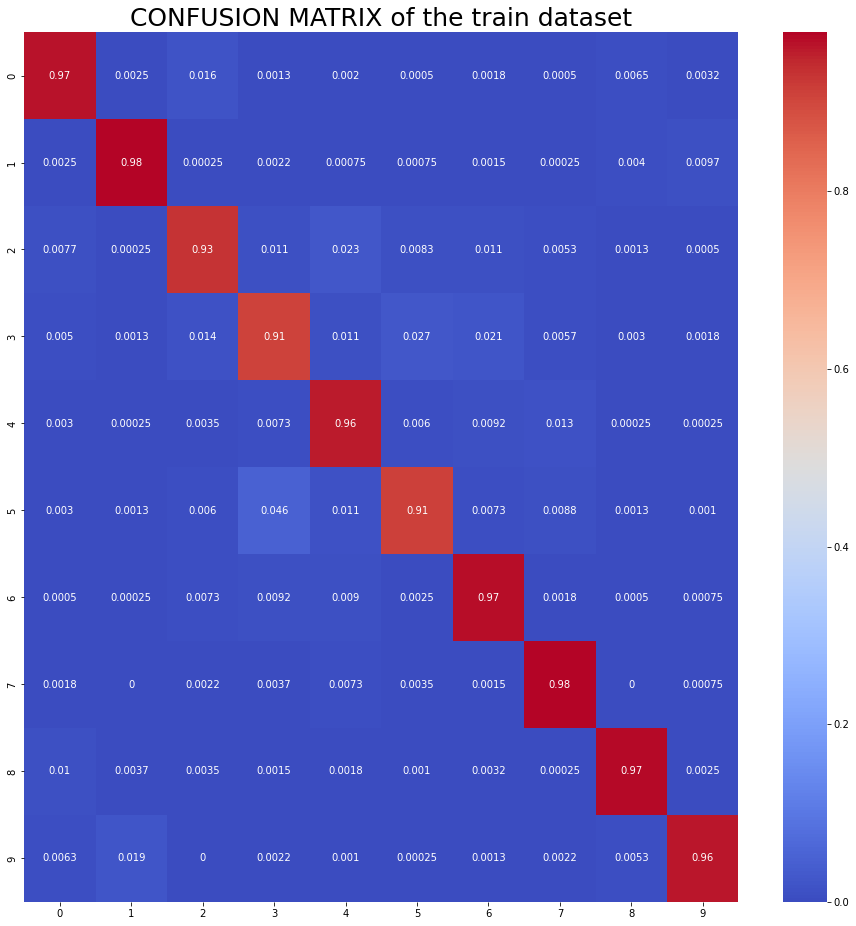

In [30]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16, 16))
sns.heatmap(
    confusion_matrix(
        train_y_true,
        train_y_pred,
        normalize ='true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the train dataset", fontsize=25)
plt.show()

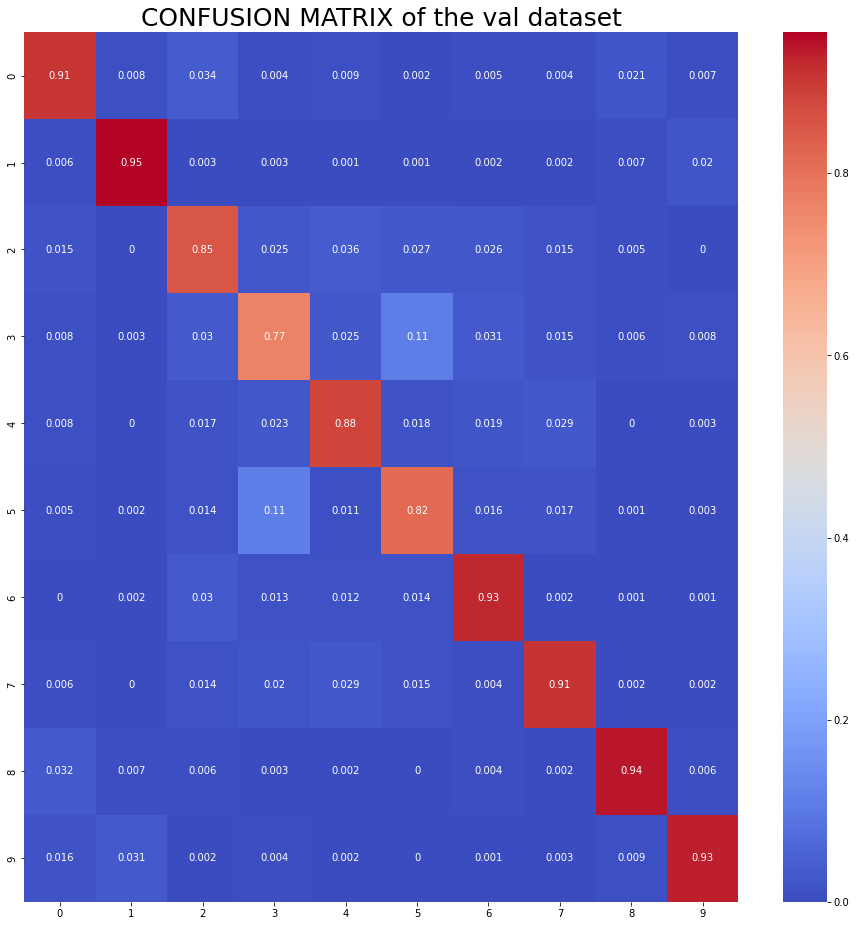

In [31]:
plt.figure(figsize=(16, 16))
sns.heatmap(
    confusion_matrix(
        val_y_true,
        val_y_pred,
        normalize = 'true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the val dataset", fontsize=25)
plt.show()

# 추론 

이제 학습이 완료되었습니다! 

그럼 test 데이터를 예측해 보아요.

test 데이터를 불어옵니다.

In [32]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + "test/*.jpg")):
    an_img = PIL.Image.open(filename) 
    img_array = np.array(an_img) 
    test_images.append(img_array) 

test_images = np.array(test_images)

In [33]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(image=self.img_list[idx]), self.img_labels[idx]

In [34]:
test_set = CustomDataset(transform=else_transform)

test_loader = DataLoader(test_set, batch_size = test_batch_size)

In [35]:
def test(model, loader, epoch, nb_epochs):

    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)

In [36]:
next(iter(test_loader))[0]['image'][0].shape

torch.Size([3, 128, 128])

본격적으로 test 데이터를 예측해보아요! 

예측을 할 때는 학습이 진행되지 않도록 net.eval() 코드를 작성해주어야 합니다. 

데이터가 backpropagation 되어 가중치가 수정되지 않도록 해주는 코드입니다. 

In [37]:
import pandas as pd
sample_submission = pd.read_csv('./data/sample_submission.csv')

model.eval()

batch_index = 0
with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        images = images['image'].to(device)
        outputs = model(images)
        batch_index = i * test_batch_size
        max_vals, max_indices = torch.max(outputs, 1)
        sample_submission.iloc[batch_index:batch_index + test_batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

예측된 데이터의 라벨은 숫자로 되어있습니다. 

train 데이터를 불러올 때 ImageFolder 메소드를 사용해 데이터를 불러왔기 때문입니다. 

제출을 위해 라벨을 다시 복원 시켜 줍니다.

In [38]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)

In [39]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,bird
2,0002.jpg,airplane
3,0003.jpg,horse
4,0004.jpg,airplane


In [40]:
sample_submission.to_csv(f'{np.max(val_acc_list):.4f}_'+f'{save_name}.csv', index=False)

축하합니다! 데이터 분석을 완료하셨습니다!

앞으로도 데이콘과 함께 즐겁게 데이터 분석 능력을 키워가시면 좋겠습니다.

감사합니다.